In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
synthetic_calls_path = '../data/binom_synthetic_calls.csv'
synthetic_puts_path = '../data/binom_synthetic_puts.csv'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """

    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
synthetic_calls = pd.read_csv(synthetic_calls_path, index_col=0)
synthetic_puts = pd.read_csv(synthetic_puts_path, index_col=0)

synthetic_calls = reduce_mem_usage(synthetic_calls)
synthetic_puts = reduce_mem_usage(synthetic_puts)

In [6]:
synthetic_options = pd.concat([synthetic_calls, synthetic_puts], axis=0)
synthetic_options = shuffle(synthetic_options, random_state=0)
synthetic_options = synthetic_options.reset_index()
synthetic_options = synthetic_options.drop('index', axis=1)

In [7]:
synthetic_options.head(5)

,Price,Strike,Type,Vol,Interest Rate,Time to Expiration,Option Price
0,100,97.0,C,0.799805,0.070007,0.600098,27.125000
1,100,101.0,P,0.500000,0.099976,0.600098,12.671875
2,100,90.0,P,0.300049,0.059998,0.899902,4.707031
3,100,104.0,P,0.899902,0.090027,0.899902,30.390625
4,100,144.0,C,1.000000,0.099976,0.899902,28.078125


# Preprocessing

In [8]:
synthetic_options = pd.get_dummies(synthetic_options, prefix='', prefix_sep='')

In [9]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(synthetic_options.drop('Option Price', axis=1))
output_data = output_sc.fit_transform(synthetic_options['Option Price'].values.reshape(-1, 1))

train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(input_data) * train_size))
last_val_idx = last_train_idx + int(np.round(len(input_data) * val_size))

X_train = input_data[0:last_train_idx]
X_val = input_data[last_train_idx:last_val_idx]
X_test = input_data[last_val_idx:]

y_train = output_data[0:last_train_idx]
y_val = output_data[last_train_idx:last_val_idx]
y_test = output_data[last_val_idx:]

In [10]:
X_train = Variable(torch.Tensor(X_train))
X_val = Variable(torch.Tensor(X_val))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_val = Variable(torch.Tensor(y_val))
y_test = Variable(torch.Tensor(y_test))

 # Model

In [11]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [13]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size):
      super(HiddenLayer, self).__init__()
      self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU()
      )
    
  def forward(self, x):
    return self.layer(x)

In [14]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    self.net = nn.Sequential(
        nn.Linear(self.input_size, self.hidden_size),
        nn.LeakyReLU(),
        HiddenLayer(self.hidden_size),
        HiddenLayer(self.hidden_size),
        HiddenLayer(self.hidden_size),
        HiddenLayer(self.hidden_size),  
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

# Training

In [16]:
input_size = 7
hidden_size = 400
output_size = 1
batch_size = 1208
epochs = 1000
lr = 1e-4

model = Net(input_size, output_size, hidden_size)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
model = model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [18]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

In [19]:
def evaluate(model, loss_fn, X_val, y_val):
  model.eval()
  with torch.no_grad():
    out = model(X_val)
    loss = loss_fn(out, y_val)
    print('\nVal set: Average loss: {:.8f}\n'.format(
            loss.item()))
    return loss.item()

In [20]:
def train(
    epochs, 
    batch_size, 
    model,
    optimizer,
    loss_fn, 
    X_train,
    y_train,
    X_val,
    y_val
):

  training_losses = []
  validation_losses = []

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()
    i = 0

    for batch, batch_labels in DataLoader(OptDataset(X_train, y_train), batch_size=batch_size):
      out = model(batch.to(device))
      optimizer.zero_grad()

      loss = loss_fn(out, batch_labels.to(device))
      epoch_losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(X_train) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1
    
    training_losses.append(np.array(epoch_losses).mean())
    validation_losses.append(evaluate(model, loss_fn, X_val, y_val))

  return training_losses, validation_losses

In [21]:
load = False
save_model_path = f'../models/opt_net1_h{hidden_size}.chkpt'
val_err_df_path = f'../results/val_error_net1_h{hidden_size}.csv'

if not load:
  train_losses, val_losses = train(
      epochs, 
      batch_size, 
      model, 
      optimizer, 
      loss_fn, 
      X_train, 
      y_train,
      X_val,
      y_val)
  val_err_df = pd.DataFrame({
      'Training': train_losses, 
      'Validation': val_losses})
  val_err_df.to_csv(val_err_df_path)
  torch.save(model.state_dict(), save_model_path)
else:
  model = Net(input_size, output_size, hidden_size)
  model.load_state_dict(torch.load(save_model_path, map_location=device))
  val_err_df = pd.read_csv(val_err_df_path, index_col=0)

| Epoch   0 |    50/  401 batches | lr 0.00010 | ms/batch 23.37 | loss 0.54724417
| Epoch   0 |   100/  401 batches | lr 0.00010 | ms/batch 19.82 | loss 0.01609074
| Epoch   0 |   150/  401 batches | lr 0.00010 | ms/batch 19.57 | loss 0.00342906
| Epoch   0 |   200/  401 batches | lr 0.00010 | ms/batch 21.23 | loss 0.00125156
| Epoch   0 |   250/  401 batches | lr 0.00010 | ms/batch 20.06 | loss 0.00063759
| Epoch   0 |   300/  401 batches | lr 0.00010 | ms/batch 20.93 | loss 0.00041278
| Epoch   0 |   350/  401 batches | lr 0.00010 | ms/batch 19.59 | loss 0.00030951

Val set: Average loss: 0.00035702

| Epoch   1 |    50/  401 batches | lr 0.00010 | ms/batch 21.23 | loss 0.00027978
| Epoch   1 |   100/  401 batches | lr 0.00010 | ms/batch 19.51 | loss 0.00021259
| Epoch   1 |   150/  401 batches | lr 0.00010 | ms/batch 21.10 | loss 0.00019219
| Epoch   1 |   200/  401 batches | lr 0.00010 | ms/batch 19.39 | loss 0.00020192
| Epoch   1 |   250/  401 batches | lr 0.00010 | ms/batch 19.2

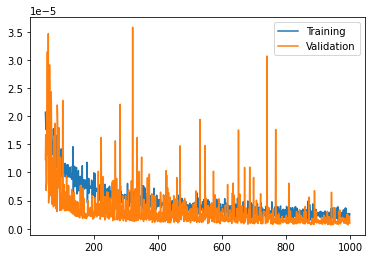

In [30]:
val_err_df[50:].plot();

# Test the model

In [23]:
test_size = 30
test_out = model(X_test[0:test_size])
test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [24]:
cols = ['Price', 'Strike', 'Vol', 'Interest Rate', 'Time to Expiration', 'C', 'P', 'Prediction', 'Real']
test_options = pd.DataFrame(columns=cols)

In [25]:
for i, item in enumerate(input_sc.inverse_transform(X_test[0:test_size].cpu().detach().numpy())):
  opt = {
      'Price': item[0],
      'Strike': item[1],
      'Vol': item[2],
      'Interest Rate': item[3],
      'Time to Expiration': item[4],
      'C': item[5],
      'P': item[6],
      'Prediction': test_out[i][0],
      'Real': real_out[i][0]
  }
  test_options = test_options.append(opt, ignore_index=True)

In [26]:
test_options['Moneyness'] = test_options.Price / test_options.Strike
test_options['Abs Error'] = np.abs(test_options.Prediction - test_options.Real)

In [27]:
test_options.sort_values('Abs Error')

,Price,Strike,Vol,Interest Rate,Time to Expiration,C,P,Prediction,Real,Abs Error,Moneyness
5,100.0,106.004311,0.449889,0.090037,0.299931,0.0,1.0,11.648286,11.648443,0.000157,0.943358
3,100.0,183.019333,0.149950,0.070009,0.700190,0.0,1.0,74.271530,74.270325,0.001205,0.546390
26,100.0,156.010330,0.500008,0.090037,0.899759,0.0,1.0,51.000656,50.999207,0.001450,0.640983
14,100.0,74.983337,0.649872,0.099995,0.999894,1.0,0.0,40.977146,40.975533,0.001614,1.333630
13,100.0,136.003662,0.149950,0.099995,0.399785,0.0,1.0,30.673155,30.671242,0.001913,0.735274
7,100.0,154.009659,0.350003,0.070009,0.299931,0.0,1.0,50.938190,50.933949,0.004242,0.649310
27,100.0,156.010330,0.749969,0.009982,0.799764,1.0,0.0,12.566317,12.562060,0.004256,0.640983
22,100.0,62.979340,0.250047,0.009982,0.399785,1.0,0.0,37.261871,37.255806,0.006065,1.587822
25,100.0,185.019989,0.149950,0.040010,0.799764,0.0,1.0,79.197014,79.203850,0.006836,0.540482
20,100.0,147.007324,0.799947,0.029996,0.100082,1.0,0.0,0.860525,0.867769,0.007244,0.680238


### MSE on the test set

In [31]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The MSE on the test set is: ', loss.item())

The MSE on the test set is:  1.0072627674162504e-06


### MAE on the test set

In [34]:
model.eval()
mae_loss = nn.L1Loss()
with torch.no_grad():
    out = model(X_test)
    loss = mae_loss(out, y_test)
    print('The MAE on the test set is: ', loss.item())

The MAE on the test set is:  0.0008061548578552902


### RSME on the test set

In [33]:
model.eval()
with torch.no_grad():
    out = model(X_test)
    loss = loss_fn(out, y_test)
    print('The RMSE on the test set is: ', np.sqrt(loss.item()))

The RMSE on the test set is:  0.0010036248140696056


### MAPE on the test set

In [35]:
def mape_loss(y_pred, y):
  return sum([np.abs(y_i - hy_i) / y_i for y_i, hy_i in zip(y_pred, y)]) / len(y_pred)

In [36]:
model.eval()
with torch.no_grad():
    out = model(X_test).squeeze().cpu().detach().numpy()
    loss = mape_loss(out, y_test.squeeze().cpu().detach().numpy())
    print('The MAPE on the test set is: ', loss)

The MAPE on the test set is:  -0.0005524449702933156


### $R^2$

In [74]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    out = model(X_test).squeeze().cpu().detach().numpy()

y_true = y_test.cpu().squeeze().detach().numpy()

r2 = r2_score(y_pred=out, y_true=y_true)

print('the R^2 score is: ', r2)

the R^2 score is:  0.9999989915294721


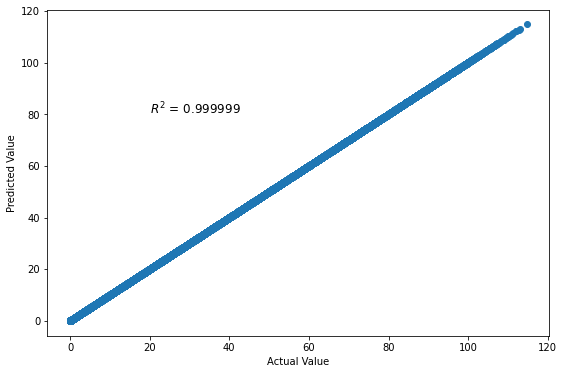

In [80]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

ax.scatter(
    y=output_sc.inverse_transform(out.reshape(-1, 1)),
    x=output_sc.inverse_transform(y_true.squeeze().reshape(-1, 1))
)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')

ax.text(20, 80, f'$R^2$ = {np.round(r2, 6)}', fontsize=12)

plt.show()